In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smectic-phase/5cb_temp_34.1869.jpeg
/kaggle/input/smectic-phase/5cb_temp_31.7576.jpeg
/kaggle/input/smectic-phase/5cb_temp_32.6768.jpeg
/kaggle/input/smectic-phase/5cb_temp_31.0354.jpeg
/kaggle/input/smectic-phase/5cb_temp_31.6263.jpeg
/kaggle/input/smectic-phase/5cb_temp_33.9242.jpeg
/kaggle/input/smectic-phase/5cb_temp_34.3182.jpeg
/kaggle/input/smectic-phase/5cb_temp_29.0000.jpeg
/kaggle/input/smectic-phase/5cb_temp_32.7424.jpeg
/kaggle/input/smectic-phase/5cb_temp_39.1667.jpeg
/kaggle/input/smectic-phase/5cb_temp_35.3030 (1).jpeg
/kaggle/input/smectic-phase/5cb_temp_33.2677.jpeg
/kaggle/input/smectic-phase/5cb_temp_33.7273.jpeg
/kaggle/input/smectic-phase/5cb_temp_29.3283.jpeg
/kaggle/input/smectic-phase/5cb_temp_34.4495.jpeg
/kaggle/input/smectic-phase/5cb_temp_33.1364.jpeg
/kaggle/input/smectic-phase/5cb_temp_33.2020.jpeg
/kaggle/input/smectic-phase/5cb_temp_29.8535.jpeg
/kaggle/input/smectic-phase/5cb_temp_33.8586.jpeg
/kaggle/input/smectic-phase/5cb_temp_31.6919 (

In [2]:
!pip install tensorflow keras numpy matplotlib

In [3]:
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
import os


2025-05-03 07:28:10.724893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746257290.999127      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746257291.077956      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import shutil
import random
import cv2
import numpy as np
import imgaug.augmenters as iaa

# === Paths ===
dataset_5CB_nematic = "/kaggle/input/nematic-phase"
dataset_5CB_isotropic = "/kaggle/input/isotropic-phase"
dataset_5CB_smectic='/kaggle/input/smectic-phase'
output_path = "/kaggle/working/binary1-classification-dataset"

# === Categories ===
categories = {
    "nematic": dataset_5CB_nematic,
    "isotropic": dataset_5CB_isotropic,
    'smectic': dataset_5CB_smectic
}

# === Split ratios ===
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# === Create directory structure ===
for split in ["train", "val", "test"]:
    for category in categories.keys():
        os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

# === Define augmentation pipeline ===
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-20, 20), scale=(0.8, 1.2)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
    iaa.Multiply((0.8, 1.2)),
    iaa.GammaContrast((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(0, 1.0)),
])

# === Split and augment ===
for category, source_folder in categories.items():
    images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    train_split = int(train_ratio * len(images))
    val_split = int(val_ratio * len(images))

    for i, img_name in enumerate(images):
        img_path = os.path.join(source_folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Skipping unreadable image: {img_name}")
            continue

        if i < train_split:
            split = "train"
        elif i < train_split + val_split:
            split = "val"
        else:
            split = "test"

        # Base filename
        base, ext = os.path.splitext(img_name)
        base_filename = f"{category}_{i}"

        # Save original image
        dst_dir = os.path.join(output_path, split, category)
        original_path = os.path.join(dst_dir, f"{base_filename}_orig.jpg")
        cv2.imwrite(original_path, img)

        # Generate and save 9 augmentations (total = 10 images per original)
        aug_images = augmenter(images=[img] * 9)
        for j, aug_img in enumerate(aug_images):
            aug_path = os.path.join(dst_dir, f"{base_filename}_aug{j+1}.jpg")
            cv2.imwrite(aug_path, aug_img)

        print(f"✅ {split.upper()} - {category} - {img_name} augmented")

print(f"\n🎉 Dataset split and augmented successfully at: {output_path}")


✅ TRAIN - nematic - 5cb_temp_26.50_copy_0002.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_26.50_copy_0001.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_27.50_copy_0002.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_26.50_copy_0004.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_25.50_copy_0001.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_25.50_copy_0003.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_26.50_copy_0005.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_27.50_copy_0004.jpeg augmented
✅ TRAIN - nematic - 5cb_temp_27.50_copy_0003.jpeg augmented
✅ VAL - nematic - 5cb_temp_25.50_copy_0002.jpeg augmented
✅ VAL - nematic - 5cb_temp_25.50_copy_0005.jpeg augmented
✅ TEST - nematic - 5cb_temp_27.50_copy_0005.jpeg augmented
✅ TEST - nematic - 5cb_temp_27.50_copy_0001.jpeg augmented
✅ TEST - nematic - 5cb_temp_25.50_copy_0004.jpeg augmented
✅ TRAIN - isotropic - 5cb_temp_37.10_copy_0004.jpeg augmented
✅ TRAIN - isotropic - 5cb_temp_39.00_copy_0002.jpeg augmented
✅ TRAIN - isotropic - 5cb_temp_40.00_copy_0

In [5]:
print("\n📁 Dataset Split Summary:")
for split in ["train", "val", "test"]:
    print(f"\n🔹 {split.upper()} SET")
    for category in categories.keys():
        folder_path = os.path.join(output_path, split, category)
        num_images = len(os.listdir(folder_path))
        print(f"  - {category}: {num_images} images")


📁 Dataset Split Summary:

🔹 TRAIN SET
  - nematic: 90 images
  - isotropic: 260 images
  - smectic: 760 images

🔹 VAL SET
  - nematic: 20 images
  - isotropic: 70 images
  - smectic: 210 images

🔹 TEST SET
  - nematic: 30 images
  - isotropic: 50 images
  - smectic: 120 images


In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/kaggle/working/binary1-classification-dataset'


class FFTTransform:
    def __call__(self, image_tensor):
        fft_image = torch.fft.fft2(image_tensor)
        fft_shifted = torch.fft.fftshift(fft_image)  
        magnitude = torch.abs(fft_shifted)
        magnitude = torch.log1p(magnitude)  
        return magnitude


transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        FFTTransform(), 
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        FFTTransform(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        FFTTransform(),
        transforms.Normalize([0.5], [0.5])
    ]),
}


Here the images were transformed to tensor after resizing ensuring normalized and reduced computation time with reasonable trainable parameters 

In [10]:
datasets_dict = {
    split: datasets.ImageFolder(os.path.join(data_dir, split), transform=transform[split])
    for split in ['train', 'val', 'test']
}

class_names = datasets_dict['train'].classes
print("Classes:", class_names)

Classes: ['isotropic', 'nematic', 'smectic']


In [11]:
label_counts = [0] * len(class_names)
for _, label in datasets_dict['train']:
    label_counts[label] += 1
class_weights = [1.0 / label_counts[label] for _, label in datasets_dict['train']]
sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)


unbalanced  dataset for the three class but here we will use SMOTE approach to ensure the model treat the classes fairly 

In [13]:
# Dataloaders
dataloaders = {
    'train': DataLoader(datasets_dict['train'], batch_size=16, sampler=sampler),
    'val': DataLoader(datasets_dict['val'], batch_size=16, shuffle=False),
    'test': DataLoader(datasets_dict['test'], batch_size=16, shuffle=False)
}


In [14]:
# Model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  
model = model.to(device)
model.device = device

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s] 


In [17]:
# Loss and Optimizer 
weights_tensor = torch.tensor(
    [1.0 / label_counts[i] for i in range(len(class_names))],
    dtype=torch.float
).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [18]:
# Training Loop with live plotting
def train_model(model, epochs=10):
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss, correct = 0, 0

        for images, labels in dataloaders['train']:
            images, labels = images.to(model.device), labels.to(model.device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(dataloaders['train'])
        train_acc = correct / len(datasets_dict['train'])
        val_acc = evaluate_model(model, 'val')

        train_losses.append(train_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

In [19]:
# Evaluation Function
def evaluate_model(model, split):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in dataloaders[split]:
            images, labels = images.to(model.device), labels.to(model.device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return correct / len(datasets_dict[split])


In [20]:
train_model(model, epochs=10)


Epoch 1/10
Train Loss: 0.1462 | Train Acc: 0.8991 | Val Acc: 1.0000

Epoch 2/10
Train Loss: 0.0938 | Train Acc: 0.9586 | Val Acc: 0.8667

Epoch 3/10
Train Loss: 0.0759 | Train Acc: 0.9586 | Val Acc: 0.3067

Epoch 4/10
Train Loss: 0.0861 | Train Acc: 0.9423 | Val Acc: 0.9667

Epoch 5/10
Train Loss: 0.0135 | Train Acc: 0.9928 | Val Acc: 0.9967

Epoch 6/10
Train Loss: 0.0162 | Train Acc: 0.9883 | Val Acc: 0.9700

Epoch 7/10
Train Loss: 0.0117 | Train Acc: 0.9955 | Val Acc: 1.0000

Epoch 8/10
Train Loss: 0.0267 | Train Acc: 0.9892 | Val Acc: 1.0000

Epoch 9/10
Train Loss: 0.0486 | Train Acc: 0.9640 | Val Acc: 0.2400

Epoch 10/10
Train Loss: 0.0327 | Train Acc: 0.9856 | Val Acc: 0.8700



Test Classification Report:
              precision    recall  f1-score   support

   isotropic       0.57      1.00      0.73        50
     nematic       1.00      0.10      0.18        30
     smectic       1.00      0.92      0.96       120

    accuracy                           0.81       200
   macro avg       0.86      0.67      0.62       200
weighted avg       0.89      0.81      0.78       200

F1 Score (macro): 0.6227556427492956


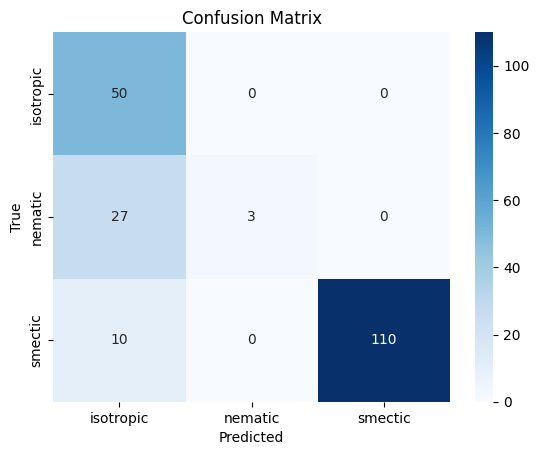

In [21]:
def test_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloaders['test']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())

    print("\nTest Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("F1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Run test
test_model(model)


In [22]:
def train_model(model, epochs=10):
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        train_loss, correct = 0, 0

        for images, labels in dataloaders['train']:
            images, labels = images.to(model.device), labels.to(model.device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()

        avg_train_loss = train_loss / len(dataloaders['train'])
        val_acc = evaluate_model(model, 'val')

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {correct/len(datasets_dict['train']):.4f} | Val Acc: {val_acc:.4f}")

    return train_losses, val_accuracies

In [23]:
train_losses, val_accuracies = train_model(model, epochs=10)


Epoch 1/10
Train Loss: 0.0438 | Train Acc: 0.9730 | Val Acc: 0.7667

Epoch 2/10
Train Loss: 0.0581 | Train Acc: 0.9577 | Val Acc: 0.9000

Epoch 3/10
Train Loss: 0.0569 | Train Acc: 0.9658 | Val Acc: 0.9533

Epoch 4/10
Train Loss: 0.0086 | Train Acc: 0.9937 | Val Acc: 1.0000

Epoch 5/10
Train Loss: 0.0063 | Train Acc: 0.9946 | Val Acc: 0.9967

Epoch 6/10
Train Loss: 0.0030 | Train Acc: 0.9964 | Val Acc: 1.0000

Epoch 7/10
Train Loss: 0.0022 | Train Acc: 0.9982 | Val Acc: 1.0000

Epoch 8/10
Train Loss: 0.0009 | Train Acc: 1.0000 | Val Acc: 1.0000

Epoch 9/10
Train Loss: 0.0003 | Train Acc: 1.0000 | Val Acc: 1.0000

Epoch 10/10
Train Loss: 0.0003 | Train Acc: 1.0000 | Val Acc: 1.0000


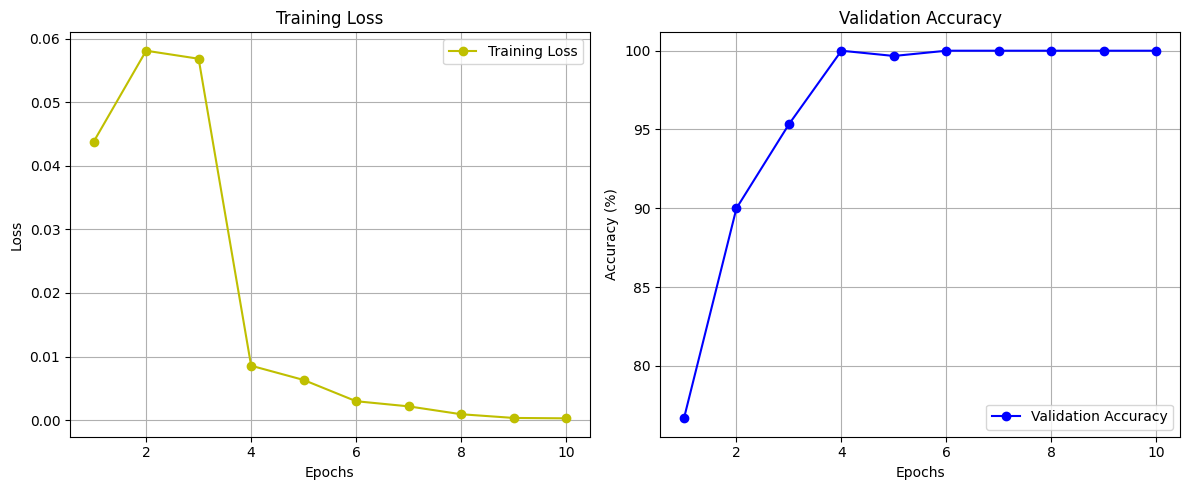

In [30]:
# Plotting training curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, 'y-o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs_range, [acc*100 for acc in val_accuracies], 'b-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

from the loss plot over epochs -in fact pre processing with FFT as slight improvement of the accuracy score 


Test Classification Report:
              precision    recall  f1-score   support

   isotropic       1.00      1.00      1.00        50
     nematic       1.00      1.00      1.00        30
     smectic       1.00      1.00      1.00       120

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

F1 Score (macro): 1.0


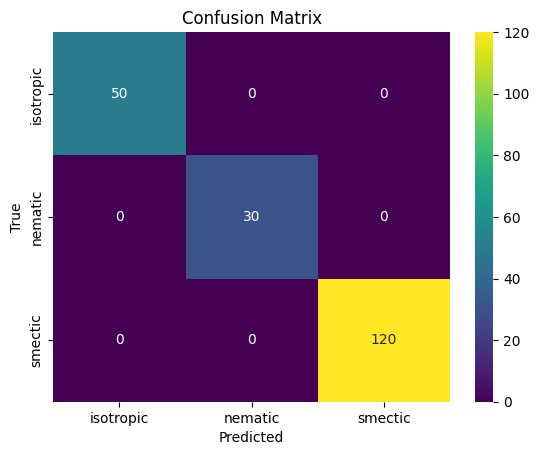

In [27]:
def test_model(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloaders['test']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())

    print("\nTest Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("F1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="viridis", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Run test
test_model(model)

In [26]:
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44283 sha256=264e535a93cd73a275193af146135b0a176570dc890f90fe

In [31]:
import warnings
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

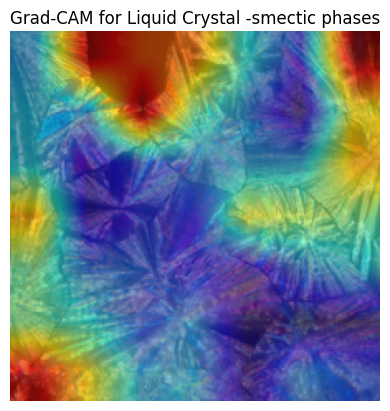

In [36]:
import warnings
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  
model = model.to(device)
model.device = device
model.eval()



img_path = "/kaggle/input/smectic-phase/5cb_temp_29.0657.jpeg"
image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input_tensor = transform(image).unsqueeze(0) 

# Normalize image for overlay
rgb_img = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

# Set target layer
target_layers = [model.layer4[-2]]


targets = [ClassifierOutputTarget(0)]

# Apply Grad-CAM
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)


plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM for Liquid Crystal -smectic phases")
plt.show()

Grad-Cam highlights these ordered regions and layering defects of pretransitional textures of smectic phase + Focal Conic Domains

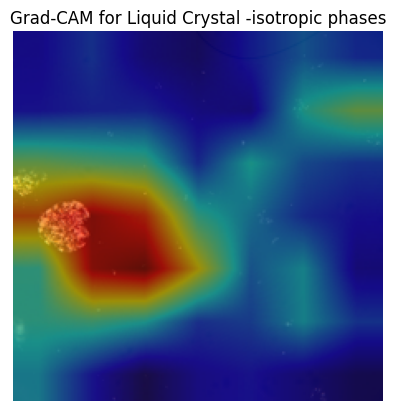

In [37]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  
model = model.to(device)
model.device = device
model.eval()



img_path = "/kaggle/input/isotropic-phase/5cb_temp_40.00_copy_0002.jpeg"
image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input_tensor = transform(image).unsqueeze(0) 

# Normalize image for overlay
rgb_img = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

# Set target layer
target_layers = [model.layer4[-1]]


targets = [ClassifierOutputTarget(0)]

# Apply Grad-CAM
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)


plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM for Liquid Crystal -isotropic phases")
plt.show()

Grad-Cam -No striped, banded, or domain-like features+ detect phase boundary fluctuations, showing patchy regions if transitioning.

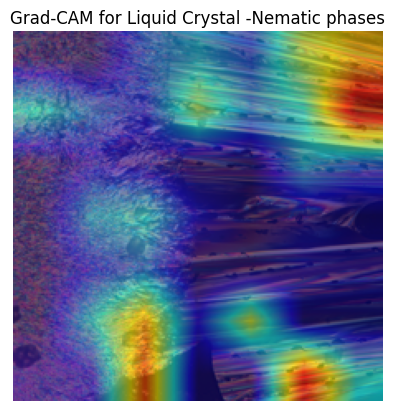

In [34]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  
model = model.to(device)
model.device = device
model.eval()



img_path = "/kaggle/input/nematic-phase/5cb_temp_27.50_copy_0001.jpeg"
image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input_tensor = transform(image).unsqueeze(0) 

# Normalize image for overlay
rgb_img = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

# Set target layer
target_layers = [model.layer4[0]]


targets = [ClassifierOutputTarget(0)]

# Apply Grad-CAM
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)


plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM for Liquid Crystal -Nematic phases")
plt.show()

High activation around Schlieren brushes, especially near disclination cores

In [ ]:
! pip install torch
torch.save(model, 'my_cnn_model.pt')